# Unmixing on synthetic dataset
See the report for further information

In [1]:
import matplotlib.pyplot as plt
import numpy as np

/home/javisty/.cache/pypoetry/virtualenvs/spectral-unmixing-ySeSU3NM-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/javisty/.cache/pypoetry/virtualenvs/spectral-unmixing-ySeSU3NM-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/javisty/.cache/pypoetry/virtualenvs/spectral-unmixing-ySeSU3NM-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


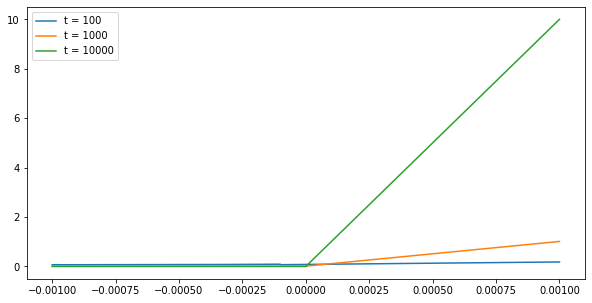

In [15]:
# Visualisation of log-barrier extension for different values of t
x = np.linspace(-0.001, 0.001, 1000)

plt.figure(figsize=(10, 5))
for t in [100, 1000, 10000]:
    y = np.where(x < -1/t**2, -np.log(-x)/t, t * x - np.log(1/t**2)/t - 1/t)
    plt.plot(x, y, label=f"t = {t}")
    
plt.legend()

In [1]:
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mat = loadmat('data/test_variability_smooth_6.mat')
mat = {k:v for k, v in mat.items() if k[0] != '_'}

In [4]:
P, N, M, W = int(mat['P']), int(mat['H']), int(mat['W']), int(mat['L'])
trueSignatures = mat['Mth'].T
trueSignaturesImage = np.pad(trueSignatures.reshape((1, 1, P, W)), ((0, N-1), (0,M-1), (0,0), (0,0)), mode='edge')
variabilities = mat['dMth'][0]

for idx, variab in enumerate(variabilities):
    trueSignaturesImage[idx//M, idx%M] += variab.T

trueSpectra = mat['data']
trueAbundances = mat['Ath'].reshape((P, N, M)).transpose((1, 2, 0))
A0, M0 = mat['A0'].T.reshape((N, M, P)), mat['M0'].T

## Prepare to Torch

In [5]:
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

In [6]:
trueSignaturesImage = torch.tensor(trueSignaturesImage, dtype=dtype, device=device)
trueSpectra = torch.tensor(trueSpectra, dtype=dtype, device=device)
trueAbundances = torch.tensor(trueAbundances, dtype=dtype, device=device)
A0, M0 = torch.tensor(A0, dtype=dtype, device=device), torch.tensor(M0, dtype=dtype, device=device)

## Initialize parameters (and saving)

In [7]:
from InfraRender.util import EndmemberLibrary
from InfraRender.InfraRender import DispersionModelEstimator
from InfraRender.util import truncate_nonzero, get_next_index, cropFeelyEndmembers, create_result_directory

In [8]:
# Wevelengths, taken from https://github.com/pthouvenin/synthetic-hs-variability/blob/master/spectres.txt
wavenumbers = np.array([0.400000, 0.401000, 0.402000, 0.403000, 0.404000, 0.405000, 0.406000, 0.407000, 0.408000, 0.409000, 0.410000, 0.411000, 0.412000, 0.413000, 0.414000, 0.415000, 0.416000, 0.417000, 0.418000, 0.419000, 0.420000, 0.421000, 0.422000, 0.423000, 0.424000, 0.425000, 0.426000, 0.427000, 0.428000, 0.429000, 0.430000, 0.431000, 0.432000, 0.433000, 0.434000, 0.435000, 0.436000, 0.437000, 0.438000, 0.439000, 0.440000, 0.441000, 0.442000, 0.443000, 0.444000, 0.445000, 0.446000, 0.447000, 0.448000, 0.449000, 0.450000, 0.451000, 0.452000, 0.453000, 0.454000, 0.455000, 0.456000, 0.457000, 0.458000, 0.459000, 0.460000, 0.461000, 0.462000, 0.463000, 0.464000, 0.465000, 0.466000, 0.467000, 0.468000, 0.469000, 0.470000, 0.471000, 0.472000, 0.473000, 0.474000, 0.475000, 0.476000, 0.477000, 0.478000, 0.479000, 0.480000, 0.481000, 0.482000, 0.483000, 0.484000, 0.485000, 0.486000, 0.487000, 0.488000, 0.489000, 0.490000, 0.491000, 0.492000, 0.493000, 0.494000, 0.495000, 0.496000, 0.497000, 0.498000, 0.499000, 0.500000, 0.501000, 0.502000, 0.503000, 0.504000, 0.505000, 0.506000, 0.507000, 0.508000, 0.509000, 0.510000, 0.511000, 0.512000, 0.513000, 0.514000, 0.515000, 0.516000, 0.517000, 0.518000, 0.519000, 0.520000, 0.521000, 0.522000, 0.523000, 0.524000, 0.525000, 0.526000, 0.527000, 0.528000, 0.529000, 0.530000, 0.531000, 0.532000, 0.533000, 0.534000, 0.535000, 0.536000, 0.537000, 0.538000, 0.539000, 0.540000, 0.541000, 0.542000, 0.543000, 0.544000, 0.545000, 0.546000, 0.547000, 0.548000, 0.549000, 0.550000, 0.551000, 0.552000, 0.553000, 0.554000, 0.555000, 0.556000, 0.557000, 0.558000, 0.559000, 0.560000, 0.561000, 0.562000, 0.563000, 0.564000, 0.565000, 0.566000, 0.567000, 0.568000, 0.569000, 0.570000, 0.571000, 0.572000, 0.573000, 0.574000, 0.575000, 0.576000, 0.577000, 0.578000, 0.579000, 0.580000, 0.581000, 0.582000, 0.583000, 0.584000, 0.585000, 0.586000, 0.587000, 0.588000, 0.589000, 0.590000, 0.591000, 0.592000, 0.593000, 0.594000, 0.595000, 0.596000, 0.597000, 0.598000, 0.599000, 0.600000, 0.601000, 0.602000, 0.603000, 0.604000, 0.605000, 0.606000, 0.607000, 0.608000, 0.609000, 0.610000, 0.611000, 0.612000, 0.613000, 0.614000, 0.615000, 0.616000, 0.617000, 0.618000, 0.619000, 0.620000, 0.621000, 0.622000, 0.623000, 0.624000, 0.625000, 0.626000, 0.627000, 0.628000, 0.629000, 0.630000, 0.631000, 0.632000, 0.633000, 0.634000, 0.635000, 0.636000, 0.637000, 0.638000, 0.639000, 0.640000, 0.641000, 0.642000, 0.643000, 0.644000, 0.645000, 0.646000, 0.647000, 0.648000, 0.649000, 0.650000, 0.651000, 0.652000, 0.653000, 0.654000, 0.655000, 0.656000, 0.657000, 0.658000, 0.659000, 0.660000, 0.661000, 0.662000, 0.663000, 0.664000, 0.665000, 0.666000, 0.667000, 0.668000, 0.669000, 0.670000, 0.671000, 0.672000, 0.673000, 0.674000, 0.675000, 0.676000, 0.677000, 0.678000, 0.679000, 0.680000, 0.681000, 0.682000, 0.683000, 0.684000, 0.685000, 0.686000, 0.687000, 0.688000, 0.689000, 0.690000, 0.691000, 0.692000, 0.693000, 0.694000, 0.695000, 0.696000, 0.697000, 0.698000, 0.699000, 0.700000, 0.701000, 0.702000, 0.703000, 0.704000, 0.705000, 0.706000, 0.707000, 0.708000, 0.709000, 0.710000, 0.711000, 0.712000, 0.713000, 0.714000, 0.715000, 0.716000, 0.717000, 0.718000, 0.719000, 0.720000, 0.721000, 0.722000, 0.723000, 0.724000, 0.725000, 0.726000, 0.727000, 0.728000, 0.729000, 0.730000, 0.731000, 0.732000, 0.733000, 0.734000, 0.735000, 0.736000, 0.737000, 0.738000, 0.739000, 0.740000, 0.741000, 0.742000, 0.743000, 0.744000, 0.745000, 0.746000, 0.747000, 0.748000, 0.749000, 0.750000, 0.751000, 0.752000, 0.753000, 0.754000, 0.755000, 0.756000, 0.757000, 0.758000, 0.759000, 0.760000, 0.761000, 0.762000, 0.763000, 0.764000, 0.765000, 0.766000, 0.767000, 0.768000, 0.769000, 0.770000, 0.771000, 0.772000, 0.773000, 0.774000, 0.775000, 0.776000, 0.777000, 0.778000, 0.779000, 0.780000, 0.781000, 0.782000, 0.783000, 0.784000, 0.785000, 0.786000, 0.787000, 0.788000, 0.789000, 0.790000, 0.791000, 0.792000, 0.793000, 0.794000, 0.795000, 0.796000, 0.797000, 0.798000, 0.799000, 0.800000, 0.804000, 0.808000, 0.812000, 0.816000, 0.820000, 0.824000, 0.828000, 0.832000, 0.836000, 0.840000, 0.844000, 0.848000, 0.852000, 0.856000, 0.860000, 0.864000, 0.868000, 0.872000, 0.876000, 0.880000, 0.884000, 0.888000, 0.892000, 0.896000, 0.900000, 0.904000, 0.908000, 0.912000, 0.916000, 0.920000, 0.924000, 0.928000, 0.932000, 0.936000, 0.940000, 0.944000, 0.948000, 0.952000, 0.956000, 0.960000, 0.964000, 0.968000, 0.972000, 0.976000, 0.980000, 0.984000, 0.988000, 0.992000, 0.996000, 1.000000, 1.004000, 1.008000, 1.012000, 1.016000, 1.020000, 1.024000, 1.028000, 1.032000, 1.036000, 1.040000, 1.044000, 1.048000, 1.052000, 1.056000, 1.060000, 1.064000, 1.068000, 1.072000, 1.076000, 1.080000, 1.084000, 1.088000, 1.092000, 1.096000, 1.100000, 1.104000, 1.108000, 1.112000, 1.116000, 1.120000, 1.124000, 1.128000, 1.132000, 1.136000, 1.140000, 1.144000, 1.148000, 1.152000, 1.156000, 1.160000, 1.164000, 1.168000, 1.172000, 1.176000, 1.180000, 1.184000, 1.188000, 1.192000, 1.196000, 1.200000, 1.204000, 1.208000, 1.212000, 1.216000, 1.220000, 1.224000, 1.228000, 1.232000, 1.236000, 1.240000, 1.244000, 1.248000, 1.252000, 1.256000, 1.260000, 1.264000, 1.268000, 1.272000, 1.276000, 1.280000, 1.284000, 1.288000, 1.292000, 1.296000, 1.300000, 1.304000, 1.308000, 1.312000, 1.316000, 1.320000, 1.324000, 1.328000, 1.332000, 1.336000, 1.340000, 1.344000, 1.348000, 1.352000, 1.356000, 1.360000, 1.364000, 1.368000, 1.372000, 1.376000, 1.380000, 1.384000, 1.388000, 1.392000, 1.396000, 1.400000, 1.404000, 1.408000, 1.412000, 1.416000, 1.420000, 1.424000, 1.428000, 1.432000, 1.436000, 1.440000, 1.444000, 1.448000, 1.452000, 1.456000, 1.460000, 1.464000, 1.468000, 1.472000, 1.476000, 1.480000, 1.484000, 1.488000, 1.492000, 1.496000, 1.500000, 1.504000, 1.508000, 1.512000, 1.516000, 1.520000, 1.524000, 1.528000, 1.532000, 1.536000, 1.540000, 1.544000, 1.548000, 1.552000, 1.556000, 1.560000, 1.564000, 1.568000, 1.572000, 1.576000, 1.580000, 1.584000, 1.588000, 1.592000, 1.596000, 1.600000, 1.604000, 1.608000, 1.612000, 1.616000, 1.620000, 1.624000, 1.628000, 1.632000, 1.636000, 1.640000, 1.644000, 1.648000, 1.652000, 1.656000, 1.660000, 1.664000, 1.668000, 1.672000, 1.676000, 1.680000, 1.684000, 1.688000, 1.692000, 1.696000, 1.700000, 1.704000, 1.708000, 1.712000, 1.716000, 1.720000, 1.724000, 1.728000, 1.732000, 1.736000, 1.740000, 1.744000, 1.748000, 1.752000, 1.756000, 1.760000, 1.764000, 1.768000, 1.772000, 1.776000, 1.780000, 1.784000, 1.788000, 1.792000, 1.796000, 1.800000, 1.804000, 1.808000, 1.812000, 1.816000, 1.820000, 1.824000, 1.828000, 1.832000, 1.836000, 1.840000, 1.844000, 1.848000, 1.852000, 1.856000, 1.860000, 1.864000, 1.868000, 1.872000, 1.876000, 1.880000, 1.884000, 1.888000, 1.892000, 1.896000, 1.900000, 1.904000, 1.908000, 1.912000, 1.916000, 1.920000, 1.924000, 1.928000, 1.932000, 1.936000, 1.940000, 1.944000, 1.948000, 1.952000, 1.956000, 1.960000, 1.964000, 1.968000, 1.972000, 1.976000, 1.980000, 1.984000, 1.988000, 1.992000, 1.996000, 2.000000, 2.004000, 2.008000, 2.012000, 2.016000, 2.020000, 2.024000, 2.028000, 2.032000, 2.036000, 2.040000, 2.044000, 2.048000, 2.052000, 2.056000, 2.060000, 2.064000, 2.068000, 2.072000, 2.076000, 2.080000, 2.084000, 2.088000, 2.092000, 2.096000, 2.100000, 2.104000, 2.108000, 2.112000, 2.116000, 2.120000, 2.124000, 2.128000, 2.132000, 2.136000, 2.140000, 2.144000, 2.148000, 2.152000, 2.156000, 2.160000, 2.164000, 2.168000, 2.172000, 2.176000, 2.180000, 2.184000, 2.188000, 2.192000, 2.196000, 2.200000, 2.204000, 2.208000, 2.212000, 2.216000, 2.220000, 2.224000, 2.228000, 2.232000, 2.236000, 2.240000, 2.244000, 2.248000, 2.252000, 2.256000, 2.260000, 2.264000, 2.268000, 2.272000, 2.276000, 2.280000, 2.284000, 2.288000, 2.292000, 2.296000, 2.300000, 2.304000, 2.308000, 2.312000, 2.316000, 2.320000, 2.324000, 2.328000, 2.332000, 2.336000, 2.340000, 2.344000, 2.348000, 2.352000, 2.356000, 2.360000, 2.364000, 2.368000, 2.372000, 2.376000, 2.380000, 2.384000, 2.388000, 2.392000, 2.396000, 2.400000, 2.404000, 2.408000, 2.412000, 2.416000, 2.420000, 2.424000, 2.428000, 2.432000, 2.436000, 2.440000, 2.444000, 2.448000, 2.452000, 2.456000, 2.460000, 2.464000, 2.468000, 2.472000, 2.476000, 2.480000, 2.484000, 2.488000, 2.492000, 2.496000, 2.500000])

In [9]:
# search intialisation parameters, by fitting dispersion models. See https://link.springer.com/chapter/10.1007/978-3-030-58583-9_39 for more details
learning_rate_search = [1e-4, 5e-4, 5e-5]
num_modes_search = [1, 2]
num_freqs_search = [50, 75]
betas_search = [(0.99, 0.999)]

wavenumbers = torch.from_numpy(wavenumbers[::2]).to(device)  # only take half of the wavenumbers

In [10]:
# /!\ long to execute

best_models = [None for i in range(P)]
for i in range(P):
    lowest_error = 10000
    spectra = M0[i, :].to('cpu')
    print(f"Endmember {i}")

    # grid search over hyperparameters

    for learning_rate in learning_rate_search:
        if lowest_error < 1e-5:
            continue
        for num_freqs in num_freqs_search:
            if lowest_error < 1e-5:
                continue
            for num_modes in num_modes_search:
                for betas in betas_search:

                    # train model
                    model = DispersionModelEstimator(wavenumbers.cpu(), spectra, learningRate=learning_rate,
                                                     numModes=num_modes, numFreqs=num_freqs, betas=betas, device='cpu',
                                                     rho_sparsity=1e-9)
                    model.fit(epochs=20000, epsilon=1e-15, display_interval=50, prune_interval=5000,
                              min_rho=1e-6, min_gamma=1e-5)
                    print(model.loss.item())
                    if model.loss.item() < lowest_error:
                        lowest_error = model.loss.item()
                        best_models[i] = model

Endmember 0
 Epoch:19999	 Loss: 0.0051004920284530998.698055918966838e-05
 Epoch:19999	 Loss: 5.8497696328177570.1349564044120574
 Epoch:19999	 Loss: 0.000358461788708973377.199203352145932e-06
 Epoch:19999	 Loss: 5.5219008302030950.10729880592989656
Endmember 1
 Epoch:19999	 Loss: 0.00187070621737306743.739372116861257e-05
 Epoch:19999	 Loss: 6.8673804665772840.13715758399684824
 Epoch:19999	 Loss: 0.00154341307826975263.087684679700878e-05
 Epoch:19999	 Loss: 4.7726795501355560.09445964908085286
 Epoch:19999	 Loss: 0.00195696272959198753.4159547080479066e-05
 Epoch:19999	 Loss: 0.000225316614447263644.613036820471248e-06
Endmember 2
 Epoch:19999	 Loss: 0.0200821645939966470.0004000053884576306
 Epoch:19999	 Loss: 20.7992534181548550.4158601613035366
 Epoch:19999	 Loss: 0.0173225385301590540.0003461920295138998
 Epoch:19999	 Loss: 8.4012135425263550.16780696283309623
 Epoch:19999	 Loss: 0.00092540229737049341.851914976218931e-05
 Epoch:19999	 Loss: 0.025776424276996630.000597398522056

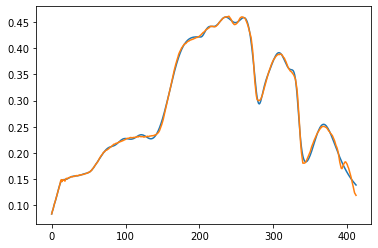

In [11]:
plt.plot(best_models[2].predictedSpectra.cpu().detach().numpy())
plt.plot(M0[2, :].cpu().detach().numpy())
plt.show()

In [15]:
for i, model in enumerate(best_models):
    model.dispersionModel.write_hdf(f"data/smooth_EMs_6.hdf", modelName=f'EM_{i}')

## Fit

In [16]:
import h5py
from torch import nn

In [18]:
from InfraRender.InfraRender.dispersion_model import DispersionModel
from InfraRender.InfraRender.dispersion_model_dict import DispersionModelDict
from InfraRender.util import MixedSpectra
from InfraRender.util import get_metrics, save_list_of_dicts, create_result_directory, consolidate_feely, create_experiment_directory
from src.regularization import DispersionRegularization, AbundanceRegularization
from src.objective import SmoothedLinearUnmixing
from src.solver import AutogradDescent

In [19]:
N_, M_ = 10, 10  # due to time complexity issues, only consider 10 x 10 images

trueSignaturesImage_ = trueSignaturesImage[:N_, :M_]
trueSpectra_ = trueSpectra[:N_, :M_]
trueAbundances_ = trueAbundances[:N_, :M_]
A0_ = A0[:N_, :M_]

In [20]:
class EMWrapper(nn.ModuleDict):
    def forward(self):
        endmemberSpectra = torch.empty((N_, M_, P, W))
        for name, model in self.items():
            idxs = name.split(', ')
            i, j, p = int(idxs[0]), int(idxs[1]), int(idxs[2])
            endmemberSpectra[i, j, p, :] = model.forward()
        return endmemberSpectra.to(device)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i in range(6):
plt.plot(best_models[2].predictedSpectra.cpu().detach().numpy())
plt.plot(M0[2, :].cpu().detach().numpy())
plt.show()

In [21]:
EM_models = dict()
f = h5py.File(f'data/smooth_EMs_6.hdf', 'r')
for p in range(P):
    for i in range(N_):
        for j in range(M_):
            print(f"\r {i} {j} {p}", end='')
            EM_models[f"{i}, {j}, {p}"] = DispersionModel(mode_hdf_group=f[f'EM_{p}'], wavenumbers=wavenumbers, dtype=dtype, device=device)

 3 9 0

/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:199: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon = torch.from_numpy(paramFile['epsilon'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:203: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_max = torch.from_numpy(paramFile['epsilon_max'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:207: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_min = torch.from_numpy(paramFile['epsilon_min'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:208: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mode_weight = torc

 9 9 5

In [22]:
model = EMWrapper(EM_models).to(device)

In [23]:
A = A0_.detach().clone().to(device).requires_grad_()

# Define terms of the objective function
regu_A = AbundanceRegularization(sparsity_penalty=0.1, barrier_penalty=1).to(device)
regu_theta = DispersionRegularization(penalty=0.1).to(device)
objective = SmoothedLinearUnmixing(trueSpectra_, model, A, regu_A, regu_theta).to(device)
solver = AutogradDescent(objective).to(device)

In [24]:
# experiment hyperparameters
p_lambda = 1e-4
rho_tol = 5e-2
gamma_tol = 5e-3
eps_tol = 1e-4
freq_tol = 1e-2
mode_weight_tol = 1e-4

for name, endmember in model.items():
    endmember.set_constraint_tolerance(freq_tolerance=freq_tol,
                                        gamma_tolerance=gamma_tol,
                                        epsilon_tolerance=eps_tol,
                                        rho_tolerance=rho_tol,
                                        mode_weight_tolerance=mode_weight_tol)

In [25]:
epochs = 1000
lr = 1e-1
betas = (0.9, 0.999)

4 6


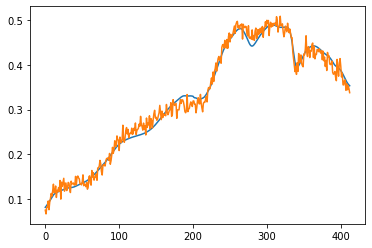

In [26]:
# Display one pixel at random
# Reconstructed spectrum from current parameters and abundances VS the true spectra
i, j = np.random.choice(N_), np.random.choice(M_)
print(i, j)
plt.plot(objective.reconstruct()[i, j].cpu().detach().numpy())
plt.plot(trueSpectra[i, j].cpu().detach().numpy())
plt.show()

In [27]:
solver.fit(trueSpectra, epochs=epochs, learning_rate=lr, betas=betas)

 Epoch 995	 Current loss: 614.24624368613218

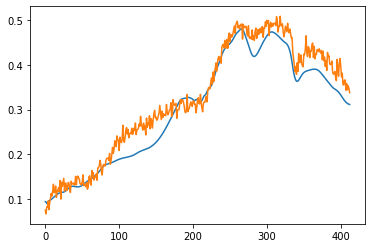

In [28]:
# After fitting
plt.plot(objective.reconstruct()[i, j].cpu().detach().numpy())
plt.plot(trueSpectra[i, j].cpu().detach().numpy())
plt.show()

## Evaluation

In [29]:
import matplotlib.pyplot as plt
from matplotlib import markers

valid_markers = ([item[0] for item in markers.MarkerStyle.markers.items() if
item[1] is not 'nothing' and not item[1].startswith('tick') and not item[1].startswith('caret')])

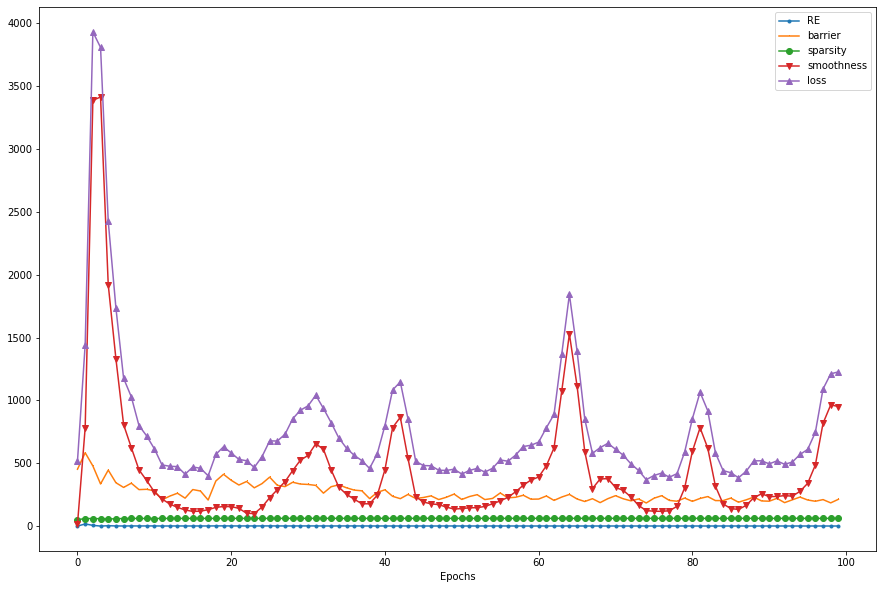

In [99]:
# Visualise some training measures for the first 100 steps
plt.figure(figsize=(15,10))
for i, (key, value) in enumerate(solver.memory.items()):
    plt.plot(value[:100], label=key, marker=valid_markers[i])
plt.xlabel("Epochs")
plt.legend()
plt.savefig('data/results_6/training_curves.png')

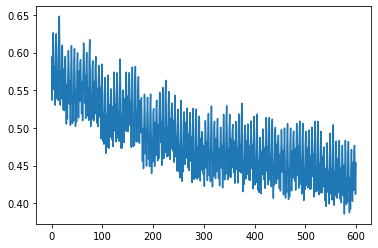

In [34]:
plt.plot(solver.memory['RE'][400:])

In [107]:
em = 0
w = wavenumbers.cpu().detach().numpy()
a0 = A0_.cpu().detach().numpy()
m0 = M0.cpu().detach().numpy()
t_sig = trueSignaturesImage_.cpu().detach().numpy()
t_ab = trueAbundances_.cpu().detach().numpy()
p_ab = solver.obj.A.cpu().detach().numpy()
p_sig = np.zeros(t_sig.shape)
for p in range(P):
    for i in range(N_):
        for j in range(M_):
            p_sig[i, j, p, :] = solver.obj.model[f'{i}, {j}, {p}'].forward().cpu().detach().numpy()

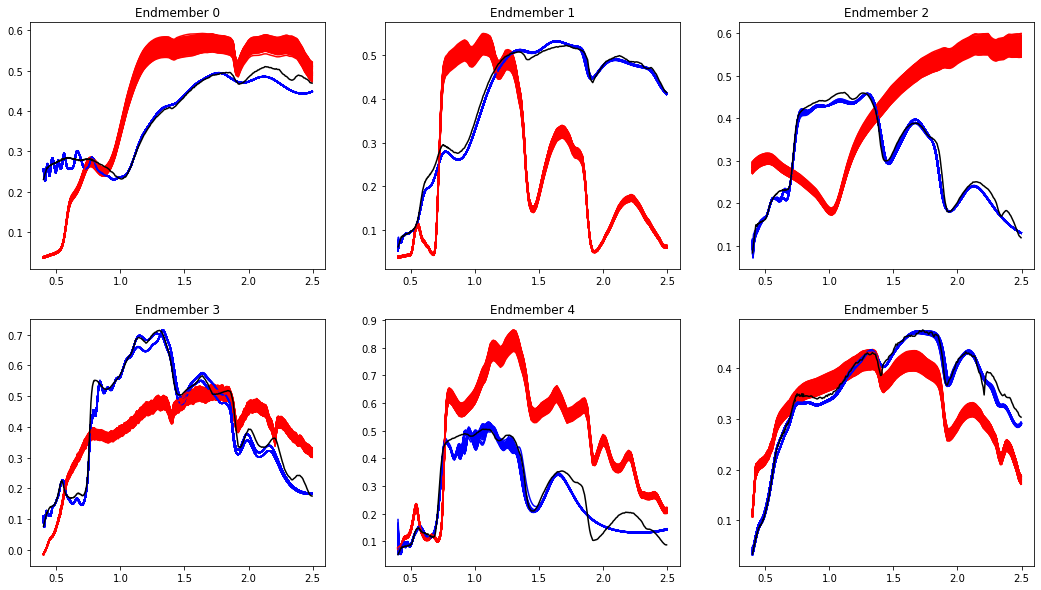

In [75]:
# Plot initial, fitted and true spectrum for the different endmembers, for all pixels
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for em in range(6):
    for i in range(N_):
        for j in range(M_):
            axs[em//3][em%3].plot(w, p_sig[i,j,em,:], color='b')
            axs[em//3][em%3].plot(w, t_sig[i,j,em,:], color='r')
    axs[em//3][em%3].plot(w, m0[em, :], color='k')
    axs[em//3][em%3].set_title(f'Endmember {em}')
plt.savefig('data/results_6/spectral_variab.png')

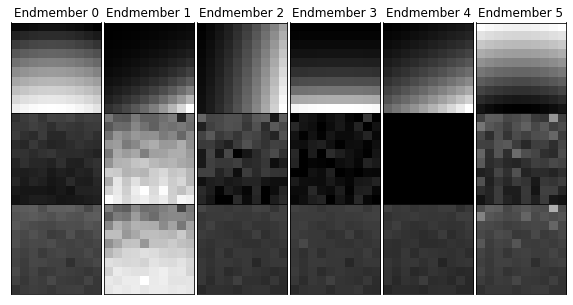

In [151]:
# Visualise true, initial and fitted abundance maps
fig, axs = plt.subplots(3, 6, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(wspace=0, hspace=0)

for em in range(6):
    axs[0][em].imshow(t_ab[:,:,em]/t_ab.max(), cmap='gray')
    axs[1][em].imshow(a0[:,:,em]/a0.max(), cmap='gray', vmin=0, vmax=1)
    axs[2][em].imshow(p_ab[:,:,em]/p_ab.max(), cmap='gray', vmin=0, vmax=1)
    axs[0][em].set_title(f'Endmember {em}')
plt.savefig('data/results_6/abundance_maps.png')

In [150]:
p_ab[:,:,4]

array([[0.13488377, 0.12031145, 0.12298081, 0.11166826, 0.12079209,
        0.11535287, 0.12819684, 0.12862115, 0.09831152, 0.11852706],
       [0.10477642, 0.11571772, 0.11721304, 0.12370058, 0.11500132,
        0.11355802, 0.1165811 , 0.10894104, 0.12944003, 0.13029065],
       [0.11425951, 0.13077031, 0.10898055, 0.10223374, 0.10576094,
        0.11935172, 0.10790584, 0.10622016, 0.1064045 , 0.12274509],
       [0.12360535, 0.11282573, 0.10534065, 0.10112614, 0.09577111,
        0.10226807, 0.12487648, 0.09401988, 0.10841095, 0.11803327],
       [0.10168896, 0.09708117, 0.10592998, 0.11139821, 0.09427842,
        0.09384623, 0.0965868 , 0.10785681, 0.10082508, 0.10769127],
       [0.09851284, 0.09755437, 0.11610029, 0.09237674, 0.11417387,
        0.1120626 , 0.10566257, 0.10271161, 0.11148342, 0.094118  ],
       [0.11439348, 0.10093119, 0.11432488, 0.11498074, 0.10080009,
        0.11273843, 0.07859653, 0.10342371, 0.11199598, 0.11446013],
       [0.11255331, 0.09574811, 0.1101269

In [132]:
# Compute some evaluation metrics
dot = np.zeros((N_, M_, P))
for i in range(N_):
    for j in range(M_):
        for p in range(P):
            dot[i,j,p] = (t_sig[i,j,p,:] @ p_sig[i,j,p,:])/(np.linalg.norm(p_sig[i,j,p,:]) * np.linalg.norm(t_sig[i,j,p,:]))

In [137]:
for i in range(6):
    asam = np.sum(np.arccos(dot[:,:,i]))/(N_*M_)
    rmse = np.linalg.norm(t_sig[:,:,i] - p_sig[:,:,i])/(N_ * M_)
    mse = np.sum((t_ab[:,:,i] - p_ab[:,:,i])**2)/(N_*M_)
    print(f'EM {i}: aSAM = {asam}, RMSE_sig = {rmse}, MSE_ab = {mse}')

EM 0: aSAM = 0.3366600353154434, RMSE_sig = 0.26585065982944356, MSE_ab = 0.1198646718542705
EM 1: aSAM = 0.634226847938887, RMSE_sig = 0.4292026642019071, MSE_ab = 0.16345242615212213
EM 2: aSAM = 0.5470098877100478, RMSE_sig = 0.415374608493652, MSE_ab = 0.012221969674462575
EM 3: aSAM = 0.34245399709658964, RMSE_sig = 0.2604707155062999, MSE_ab = 0.013616530689591642
EM 4: aSAM = 0.34135923768194787, RMSE_sig = 0.41140450864758416, MSE_ab = 0.011243371044391265
EM 5: aSAM = 0.21333898638693843, RMSE_sig = 0.1424412334262353, MSE_ab = 0.13946935586769973


In [143]:
print("Global aSAM = {},  RMSE_E = {}, MSE_ab = {}, RE = {}".format(np.sum(np.arccos(dot))/(N_*M_*P), np.linalg.norm(t_sig - p_sig)/(N_ * M_ * P), np.sum((t_ab[:,:,:] - p_ab[:,:,:])**2)/(N_*M_*P), 2*float(solver.obj.reconstruction_error())))

Global aSAM = 0.40250816535497563,  RMSE_E = 0.13792265687121444, MSE_ab = 0.07664472088042297, RE = 0.9070884182024693
